# Partial Configuration Identification


We consider performance analysis in highly variable systems, such as x264, with a large number of configurations options and input features, and multiple performance metrics.
Our goal in this work to identify partial stable configurations from a set of measurements.
A stable configuration is a configuration that is consistently high performing, indicated by its presence in the Pareto front of configurations for each of the videos in the measurement set.
In the ideal case, we identify a single configuration that is present in every Pareto front, i.e. it is never dominated by another configuration. This would be the premier configuration to test for every new input.
Otherwise, we can identify the subset of configurations options that most frequently occur together and propose these as a partial configuration. The extensions of this partial configuration can then form a reduced set of candidate configurations to consider for evaluation/application. The extensions can be similarly determined from the obtained measurements and potentially be weighted by their expected performance resp. their influence on certain performance metrics.

We raise the following research questions:
- Do stable configurations exist? Are they partial or full configurations?
- Do the best configurations share common parameters?
- What is the largest common set of parameters with minimum quality?
- How much do the results vary if we further partition the data, e.g. by video category?
   
Technically speaking, we can apply techniques from data mining, e.g. frequent itemset mining, to determine the core partial configurations, but we do not have to rely on complex statistical machine learning techniques, which makes this approach simple and interpretable.
    
We present an in-depth analysis of our approach on a large-scale dataset of video encodings using the x264 video encoder.
Additionally, we confirm the applicability of our approach on seven others configurable systems (Luc's dataset: gcc, imagemagick, lingeling, nodeJS, poppler, SQLite, xz).

First we import some packages.
`common` is our shared library for shared functions like loading, ranking, etc.

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from scipy import stats
from common import load_data, pareto_rank, baseline_results
import os
import json

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import fpgrowth, fpmax

We load the data for one system, here `x264`.

In [2]:
random_state = 1234
test_size = 0.40
pareto_cutoff = 0.4
rank_by_domination_count = False

performances = ["fps", "cpu"]
performances = ["size", "etime"]


(
    perf_matrix_initial,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(system="x264", data_dir="../data", input_properties_type="tabular")

if len(performances) == 0:
    performances = all_performances

# Normalization is needed for the Pareto cutoff
# We can normalize before splitting, because
# we normalize per input and we also split per input.
# There is no data leakage.
normalized_metrics = (
    perf_matrix_initial[["inputname"] + all_performances]
    .groupby("inputname", as_index=False)
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
cutoff_mask = (normalized_metrics <= pareto_cutoff).all(axis=1)

nmdf = (
    perf_matrix_initial[["inputname"] + all_performances]
    .groupby("inputname", as_index=True)
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
)
perf_matrix = pd.merge(
    perf_matrix_initial, nmdf, suffixes=("_raw", None), left_index=True, right_index=True
)
perf_matrix["feasible"] = cutoff_mask

all_perf_raw = [f"{p}_raw" for p in all_performances]
all_perf_norm = [f"{p}" for p in all_performances]

icm_all = (
    perf_matrix[["inputname", "configurationID"] + all_performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm_all.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: stats.rankdata(x, method="min")
)
icm_all["ranks"] = icm_all.groupby("inputname", group_keys=False).apply(
    lambda x: pareto_rank(
        x, cutoff=pareto_cutoff, rank_by_domination_count=rank_by_domination_count
    )
)

train_inp, test_inp = train_test_split(
    perf_matrix["inputname"].unique(),
    test_size=test_size,
    random_state=random_state,
)
train_perf = perf_matrix[perf_matrix.inputname.isin(train_inp)]
test_perf = perf_matrix[perf_matrix.inputname.isin(test_inp)]

all_performances

['fps', 'etime', 'cpu', 'size', 'kbs']

## Pareto Front Calculation

We take the matrix of all measurements and calculate the Pareto ranks for each configuration per input. For this, we consider all measured performances, but we can change this to any subset.

In [6]:
icm = (
    train_perf[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: stats.rankdata(x, method="min")
)
icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(
    lambda x: pareto_rank(x, cutoff=pareto_cutoff, rank_by_domination_count=rank_by_domination_count)
)

# Calculate the Pareto ranks for the test data
icm_test = (
    test_perf[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_test["ranks"] = icm_test.groupby("inputname", group_keys=False).apply(
    lambda x: pareto_rank(x, cutoff=pareto_cutoff, rank_by_domination_count=rank_by_domination_count)
)

dataset = icm[icm.ranks <= 1].join(config_features).join(input_features).reset_index()

size     etime  ranks
inputname            configurationID                           
Animation_1080P-01b3 1                0.070142  0.003932      3
                     2                0.029658  0.066841      4
                     3                0.001764  0.090433      3
                     4                0.008462  0.098296      8
                     5                0.006305  0.094364      7
...                                        ...       ...    ...
Vlog_720P-6410       197              0.242044  0.791309     18
                     198              0.241170  0.473544     18
                     199              0.222019  0.914868     18
                     200              0.222019  0.895359     18
                     201              0.033678  0.644990     18

[155172 rows x 3 columns]

For quick visualization, we plot the distribution of measurements and their ranks for one input.
The first Pareto front is in the lower left corner.

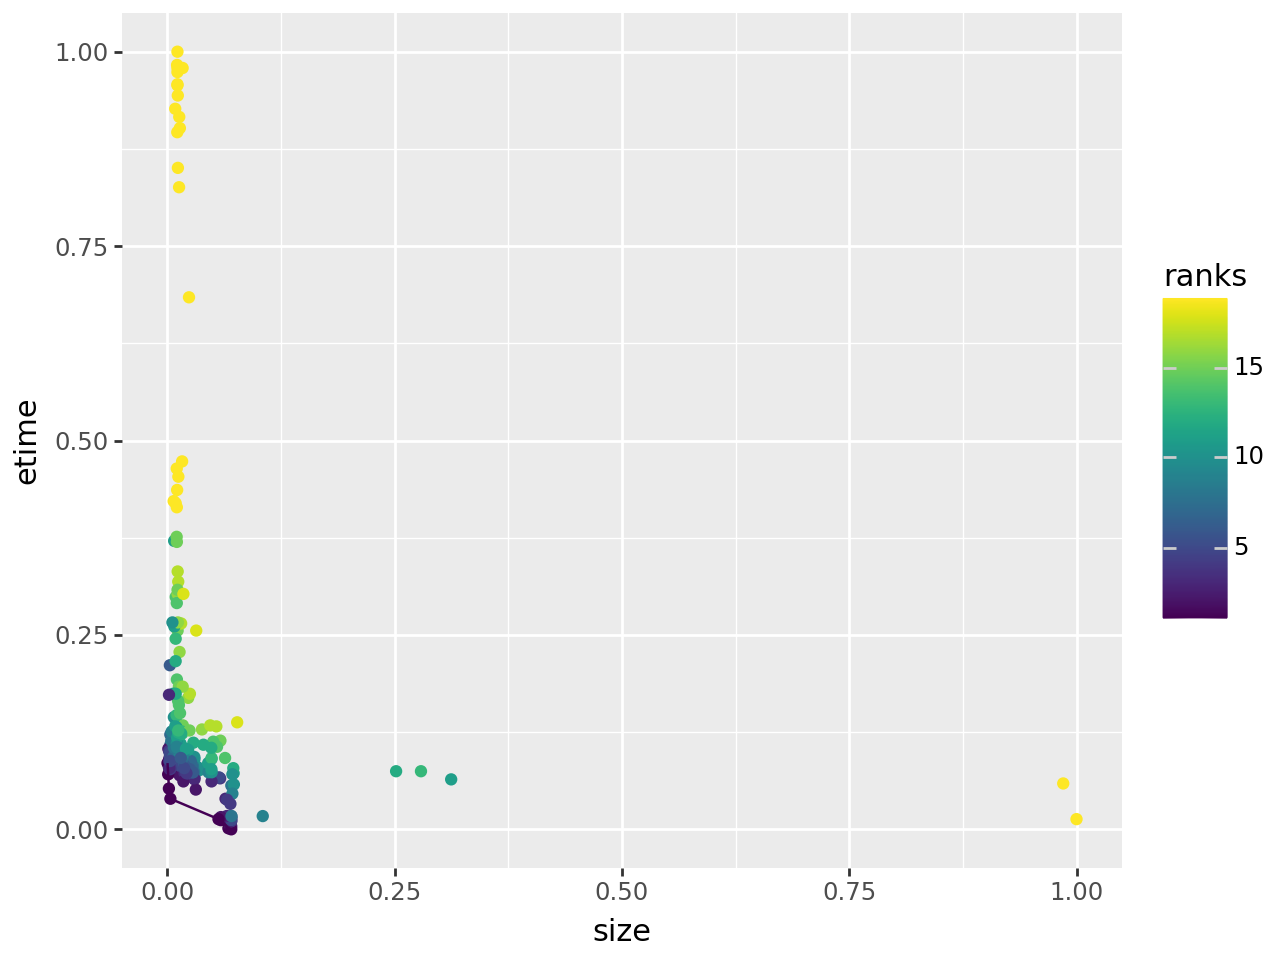

In [8]:
inputname = icm.iloc[0].name[0]
(
    p9.ggplot(icm.loc[(inputname)], p9.aes(x="size", y="etime", color="ranks"))
    + p9.geom_point()
    + p9.geom_line(icm[icm.ranks == 1].loc[(inputname)])
)

Let's look at the distribution of the ranks. How many ranks are there and how large are they over all inputs?

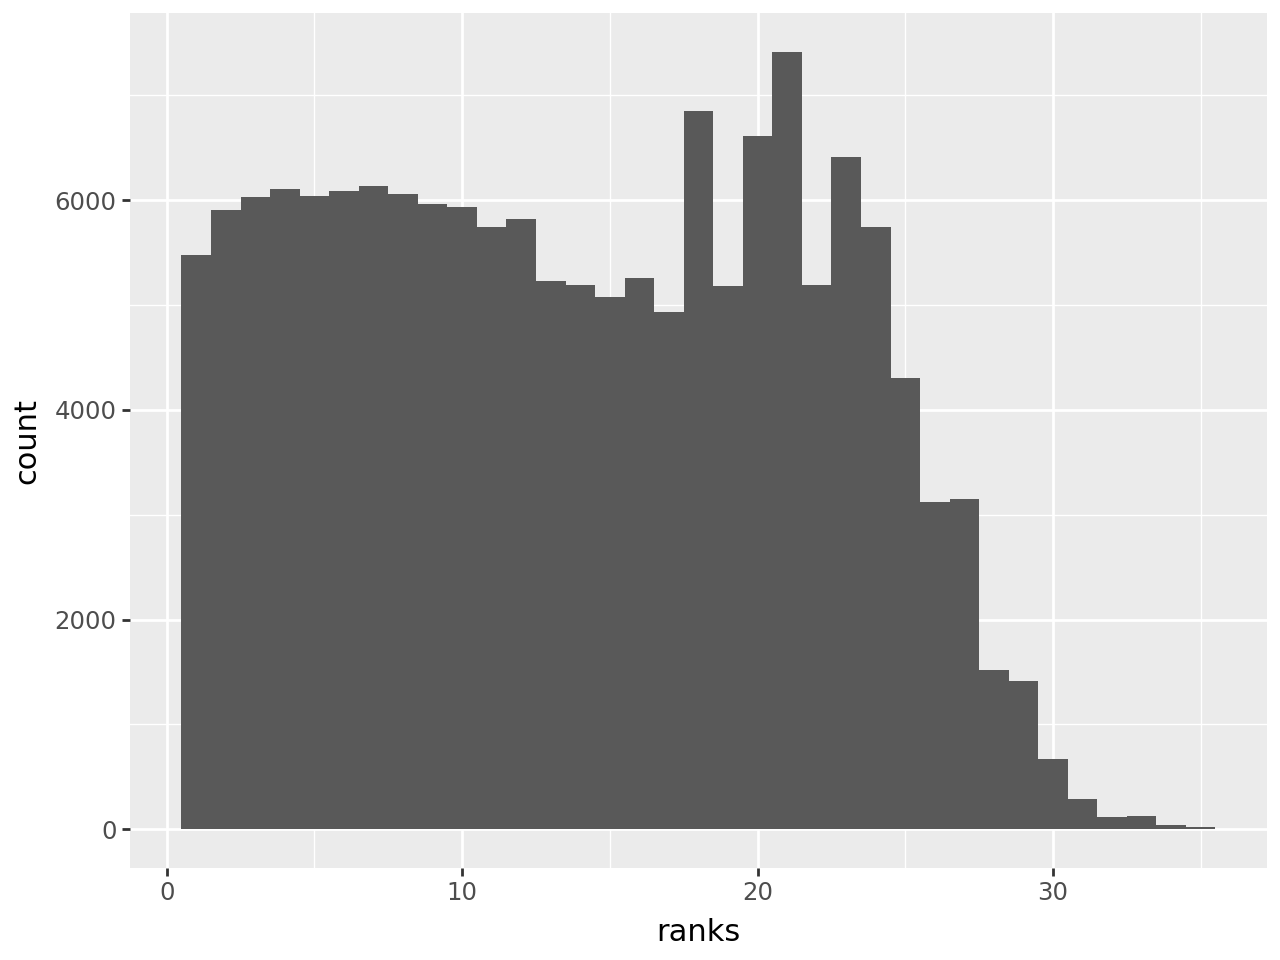

In [9]:
(
    p9.ggplot(icm, p9.aes(x="ranks"))
    + p9.geom_histogram(binwidth=1)
)

For further mining, we are only interested in the best performing configurations, i.e. the top Pareto ranks.

For the `mlxtend` itemset mining functionality, it is necessary to convert the dataset to onehot encoding.

In [11]:
def prepare(dataset):
    enc = OneHotEncoder(
        min_frequency=1,
        handle_unknown="infrequent_if_exist",
        sparse_output=False,
    )
    enc.fit(dataset)
    col_names = enc.get_feature_names_out()
    onehot_data = enc.transform(dataset)

    df = pd.DataFrame(onehot_data, columns=col_names, dtype=np.bool_)
    return df


df = prepare(dataset[config_features.columns])
print(f"One-hot encoded dataset has {df.shape[1]} columns ({dataset.shape[1]} before)")
df

One-hot encoded dataset has 78 columns (37 before)


,cabac_0,cabac_1,ref_1,ref_2,ref_3,ref_5,ref_7,ref_8,ref_16,subme_0,...,rc_lookahead_30.0,rc_lookahead_40.0,rc_lookahead_50.0,rc_lookahead_60.0,rc_lookahead_nan,scenecut_0.0,scenecut_40.0,scenecut_nan,weightb_1.0,weightb_nan
0,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,True
1,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
2,False,True,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
3,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
4,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5468,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,True
5469,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
5470,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
5471,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,True


In [13]:
# Here we export the dataset for mining with choco-mining

df2 = dataset[list(input_features.columns) + ["configurationID"]]
stacked = df2.stack()
col_val_series = pd.Series([f'{i[1]}_{v}' for i, v in zip(stacked.index, stacked.values)])
# Factorize the stacked data
factorized_data, indices = pd.factorize(col_val_series)
mapping = {i: v for i, v in enumerate(indices)}
with open('mapping.json', 'w') as fp:
    json.dump(mapping, fp)

df2_encoded = factorized_data.reshape(df2.shape).astype(int)
df2_encoded = pd.DataFrame(df2_encoded, columns=df2.columns)

np.savetxt("transactions.dat", df2_encoded.values, fmt="%d")

df2_encoded

,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category,configurationID
0,0,1,2,3,4,5,6,7,8
1,0,1,2,3,4,5,6,7,9
2,0,1,2,3,4,5,6,7,10
3,0,1,2,3,4,5,6,7,11
4,0,1,2,3,4,5,6,7,12
...,...,...,...,...,...,...,...,...,...
5468,274,275,276,2096,2566,2567,2568,2323,8
5469,274,275,276,2096,2566,2567,2568,2323,82
5470,274,275,276,2096,2566,2567,2568,2323,76
5471,274,275,276,2096,2566,2567,2568,2323,15


## FP-Growth
Extracting frequent itemsets from a dataset, i.e. which items to appear together most commonly.
We see that this gives us a lot of small itemsets, even though we are interested in the _largest_ partial configuration we can find.

In [14]:
growthdf = fpgrowth(df, min_support=0.6, use_colnames=True).sort_values("support", ascending=False)
growthdf

,support,itemsets
0,1.000000,(qpmax_69)
1,0.942262,(fast_pskip_1)
17,0.942262,"(qpmax_69, fast_pskip_1)"
157,0.914672,"(qpmax_69, me_range_16)"
7,0.914672,(me_range_16)
...,...,...
874,0.600585,"(b_pyramid_2.0, scenecut_40.0, fast_pskip_1, b..."
155,0.600219,"(me_range_16, qpmax_69, mixed_ref_0, fast_pski..."
153,0.600219,"(mixed_ref_0, me_range_16, fast_pskip_1, cabac_1)"
387,0.600037,"(me_range_16, chroma_qp_offset_0, qpmax_69, tr..."


## FP-Max 

FP-Max is a variant of FP-Growth, which focuses on obtaining maximal itemsets. 
An itemset X is said to maximal if X is frequent and there exists no frequent super-pattern containing X. 
In other words, a frequent pattern X cannot be sub-pattern of larger frequent pattern to qualify for the definition maximal itemset.

In [15]:
maxsets = fpmax(df, min_support=0.2, use_colnames=True).sort_values("support", ascending=False)
maxsets["length"] = maxsets["itemsets"].apply(len)
maxsets

,support,itemsets,length
438,0.277544,"(me_range_16, mbtree_0, chroma_qp_offset_0, qp...",10
322,0.255618,"(rc_lookahead_nan, me_range_16, mbtree_0, chro...",11
440,0.243377,"(me_range_16, chroma_qp_offset_0, qpmax_69, 8x...",11
422,0.235154,"(weightb_1.0, b_pyramid_2.0, me_range_16, caba...",16
439,0.232962,"(me_range_16, mbtree_0, chroma_qp_offset_0, qp...",10
...,...,...,...
91,0.200073,"(weightb_1.0, b_adapt_1.0, b_pyramid_2.0, caba...",13
353,0.200073,"(weightb_1.0, qpmax_69, open_gop_0.0, mixed_re...",7
100,0.200073,"(weightb_1.0, me_range_16, qpmax_69, open_gop_...",11
102,0.200073,"(weightb_1.0, chroma_qp_offset_0, qpmax_69, op...",9


In [16]:
# Only add configurations that cover previously uncovered measurements
allinds = set()
itemsets = []
for i, r in enumerate(maxsets.itemsets):
    if allinds.issuperset(df[df[r].all(axis=1)].index):
        continue

    allinds.update(df[df[r].all(axis=1)].index)
    itemsets.append(r)
    print(i, len(allinds)/df.shape[0])

print(f"Covered {len(allinds)/df.shape[0]*100:.4f}% of the dataset with {len(itemsets)} configurations")

0 0.2775443084231683
1 0.3464279188744747
2 0.5106888361045131
4 0.5457701443449662
5 0.5890736342042755
6 0.6119130275899872
7 0.6391375845057555
8 0.6882879590718071
10 0.6919422620135209
12 0.7098483464279188
15 0.7392654851087155
16 0.7684999086424265
17 0.7920701626164809
18 0.803946647177051
34 0.8203910104147634
37 0.8209391558560205
41 0.8322674949753335
42 0.8435958340946464
47 0.8788598574821853
51 0.8805042938059565
57 0.892746208660698
62 0.9090078567513247
78 0.9177781838114379
85 0.9261830805773799
86 0.9384249954321213
93 0.9393385711675498
98 0.9484743285218344
106 0.9594372373469761
112 0.9616298191120044
115 0.9680248492600037
130 0.968390279554175
137 0.9689384249954321
138 0.9760643157317742
140 0.9771606066142883
152 0.9848346427918875
153 0.9850173579389732
169 0.986296363968573
197 0.9901333820573726
212 0.9904988123515439
248 0.9926913941165723
260 0.9934222547049151
264 0.9936049698520008
279 0.9968938424995432
280 0.9978074182349717
314 0.9983555636762288
393 

In [17]:
# Only add configurations that cover previously uncovered inputs
allinds = set()
itemsets = []
for i, r in enumerate(maxsets.itemsets):
    covered_rows = df[r].all(axis=1).values
    if allinds.issuperset(dataset[covered_rows].inputname):
        continue

    allinds.update(dataset[covered_rows].inputname)
    itemsets.append(r)
    print(i, len(allinds)/dataset.inputname.nunique())

print(f"Covered {len(allinds)/dataset.inputname.nunique()*100:.4f}% of the inputs with {len(itemsets)} partial configurations")

0 0.7629533678756477
1 0.9352331606217616
2 0.9818652849740933
5 0.9844559585492227
6 0.9857512953367875
8 0.9896373056994818
12 0.9974093264248705
34 0.9987046632124352
57 1.0
Covered 100.0000% of the inputs with 9 partial configurations


In [18]:
covered_rows = df[itemsets[0]].all(axis=1).values
static_features = dataset[covered_rows][config_features.columns].nunique() == 1
static_features = static_features[static_features].index.tolist()
variable_features = [c for c in config_features.columns if c not in static_features]
static_features, variable_features

(['cabac',
  'mixed_ref',
  'me_range',
  'trellis',
  'fast_pskip',
  'chroma_qp_offset',
  'mbtree',
  'qpmax',
  'aq-mode',
  'deblock',
  'b_adapt',
  'b_pyramid',
  'open_gop',
  'weightb'],
 ['ref',
  'subme',
  '8x8dct',
  'bframes',
  'weightp',
  'analyse',
  'me',
  'direct',
  'rc_lookahead',
  'scenecut'])

In [19]:
dataset[covered_rows].groupby(variable_features).count()

inputname  \
ref subme 8x8dct bframes weightp analyse   me  direct  rc_lookahead scenecut              
1   1     0      3       1       0x3:0x113 hex spatial 40.0         40.0             96   
          1      3       1       0x3:0x3   dia auto    10.0         40.0             61   
    2     0      3       1       0x3:0x113 hex auto    10.0         40.0             90   
                                                       40.0         40.0             78   
                                               spatial 40.0         40.0            172   

                                                                              configurationID  \
ref subme 8x8dct bframes weightp analyse   me  direct  rc_lookahead scenecut                    
1   1     0      3       1       0x3:0x113 hex spatial 40.0         40.0                   96   
          1      3       1       0x3:0x3   dia auto    10.0         40.0                   61   
    2     0      3       1       0x3:0x113 hex auto    10.0         40.0                   90   
                                                       40.0         40.0                   78   
                                               spatial 40.0         40.0                  172   

                                                                              size  \
ref subme 8x8dct bframes weightp analyse   me  direct  rc_lookahead scenecut         
1   1     0      3       1       0x3:0x113 hex spatial 40.0         40.0        96   
          1      3       1       0x3:0x3   dia auto    10.0         40.0        61   
    2     0      3       1       0x3:0x113 hex auto    10.0         40.0        90   
                                                       40.0         40.0        78   
                                               spatial 40.0         40.0       172   

                                                                              etime  \
ref subme 8x8dct bframes weightp analyse   me  direct  rc_lookahead scenecut          
1   1     0      3       1       0x3:0x113 hex spatial 40.0         40.0         96   
          1      3       1       0x3:0x3   dia auto    10.0         40.0         61   
    2     0      3       1       0x3:0x113 hex auto    10.0         40.0         90   
                                                       40.0         40.0         78   
                                               spatial 40.0         40.0        172   

                                                                              ranks  \
ref subme 8x8dct bframes weightp analyse   me  direct  rc_lookahead scenecut          
1   1     0      3       1       0x3:0x113 hex spatial 40.0         40.0         96   
          1      3       1       0x3:0x3   dia auto    10.0         40.0         61   
    2     0      3       1       0x3:0x113 hex auto    10.0         40.0         90   
                                                       40.0         40.0         78   
                                               spatial 40.0         40.0        172   

                                                                              cabac  \
ref subme 8x8dct bframes weightp analyse   me  direct  rc_lookahead scenecut          
1   1     0      3       1       0x3:0x113 hex spatial 40.0         40.0         96   
          1      3       1       0x3:0x3   dia auto    10.0         40.0         61   
    2     0      3       1       0x3:0x113 hex auto    10.0         40.0         90   
                                                       40.0         40.0         78   
                                               spatial 40.0         40.0        172   

                                                                              mixed_ref  \
ref subme 8x8dct bframes weightp analyse   me  direct  rc_lookahead scenecut              
1   1     0      3       1       0x3:0x113 hex spatial 40.0         40.0             96   
          1      3       1       0x3:0x3   dia auto   

In [20]:
dataset[covered_rows][config_features.columns].nunique()[dataset[covered_rows][config_features.columns].nunique() > 1]

ref             4
subme           3
8x8dct          2
bframes         2
weightp         3
analyse         3
me              2
direct          2
rc_lookahead    2
scenecut        2
dtype: int64

In [21]:
cfg_columns = ["configurationID"] + list(config_features.columns)
top_cfgs = dataset[cfg_columns + ["inputname"]].groupby(cfg_columns, dropna=False, as_index=False).count().sort_values(
    "inputname", ascending=False
).configurationID.tolist()

In [22]:
## Here we select the configurations by decreasing coverage
# If a configuration adds new items, we add it.
# We repeat until all inputs are covered.

covered_inputs = set()
num_inputs = dataset.inputname.nunique()
input_labels = pd.Series(np.zeros(num_inputs), index=dataset.inputname.unique())
selected_configs = []

for cid in top_cfgs:
    inputnames = dataset.query("configurationID == @cid").inputname.unique()
    new_inputs = set(inputnames).difference(covered_inputs)
    input_labels[list(new_inputs)] = cid
    covered_inputs.update(new_inputs)
    selected_configs.append(cid)

    if len(covered_inputs) == num_inputs:
        print(f"Reached full coverage with {len(selected_configs)} configurations")
        break


Reached full coverage with 39 configurations


In [23]:
## Here we select the configurations by maximal gain
# We iterate over all open configurations and add that which adds the most input coverage.
# We repeat until all inputs are covered.
# The code could be more efficient, but it's good enough for x264

covered_inputs = set()
num_inputs = dataset.inputname.nunique()
input_labels = pd.Series(np.zeros(num_inputs), index=dataset.inputname.unique())
selected_configs = []
open_cfg = np.ones(len(top_cfgs), dtype=np.bool_)

while len(covered_inputs)/num_inputs < 1.0:
    max_add = 0
    max_add_id = -1
    
    for i in np.where(open_cfg)[0]:
        cid = top_cfgs[i]
        inputnames = dataset.query("configurationID == @cid").inputname.unique()
        new_inputs = set(inputnames).difference(covered_inputs)
    
        if len(new_inputs) == 0:
            open_cfg[i] = False

        if len(new_inputs) > max_add:
            max_add = len(new_inputs)
            max_add_id = i

    cid = top_cfgs[max_add_id]
    inputnames = subdf.reset_index().query("configurationID == @cid").inputname.unique()
    new_inputs = set(inputnames).difference(covered_inputs)
    input_labels[list(new_inputs)] = cid
    open_cfg[max_add_id] = False
    covered_inputs.update(new_inputs)
    selected_configs.append(cid)

    print(len(covered_inputs)/num_inputs)

print(f"Reached full coverage with {len(selected_configs)} configurations")

0.4481865284974093
0.7072538860103627
0.8588082901554405
0.9132124352331606
0.9417098445595855
0.9598445595854922
0.9727979274611399
0.9831606217616581
0.9883419689119171
0.9909326424870466
0.9935233160621761
0.9961139896373057
0.9974093264248705
0.9987046632124352
1.0
Reached full coverage with 15 configurations


In [24]:
np.unique(input_labels, return_counts=True)

(array([  3.,  11.,  12.,  43.,  47.,  65.,  68.,  69.,  71.,  72.,  74.,
         79.,  88., 130., 167.]),
 array([  4,   2,   2,  14,   1,   8,  22,  10,   1, 346,  42, 200, 117,
          1,   2]))

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek, SMOTEENN

input_labels = input_labels.sort_index()
enc = LabelEncoder()
y = enc.fit_transform(input_labels)

X = input_preprocessor.fit_transform(
    input_features.query("inputname.isin(@input_labels.index)").sort_index()
)

train_idx, val_idx = train_test_split(
    np.arange(X.shape[0]), test_size=0.2, random_state=random_state
)
X_train = X[train_idx]
X_val = X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]
inputnames_train = input_labels.index[train_idx]
inputnames_val = input_labels.index[val_idx]

# X_train = X
# y_train = y
# X_val = X
# y_val = y
# inputnames_val = input_labels.index

best_val_rank = 100_000
best_depth = 0

for i in range(1, X.shape[1]):
    print(i)
    clf = DecisionTreeClassifier(max_depth=i)
    # clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    print("Scores", clf.score(X_train, y_train), val_score)

    # Validation test
    pred_cfg_lbl = clf.predict(X_val)
    pred_cfg = enc.inverse_transform(pred_cfg_lbl).astype(int)
    inp_pred_map = pd.DataFrame(
        zip(inputnames_val, pred_cfg), columns=["inputname", "configurationID"]
    )
    val_rank = icm.merge(inp_pred_map, on=["inputname", "configurationID"])[
        "ranks"
    ].mean()
    print("Val rank", val_rank)

    if val_rank < best_val_rank:
        best_val_rank = val_rank
        best_depth = i

print(f"Best depth {best_depth}")
clf = DecisionTreeClassifier(max_depth=best_depth)
clf.fit(X, y)

pred_cfg_lbl = clf.predict(X)
pred_cfg = enc.inverse_transform(pred_cfg_lbl).astype(int)

print("Scores", clf.score(X, y))
inp_pred_map = pd.DataFrame(
    zip(inputnames_train, pred_cfg[train_idx]), columns=["inputname", "configurationID"]
)
train_rank = icm.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean()
print("Train rank", train_rank)

# Validation test
inp_pred_map = pd.DataFrame(
    zip(inputnames_val, pred_cfg[val_idx]), columns=["inputname", "configurationID"]
)
val_rank = icm.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean()
print("Val rank", val_rank)



# Test set
X_test = input_preprocessor.transform(input_features.query("inputname.isin(@test_inp)"))
pred_cfg_test = enc.inverse_transform(clf.predict(X_test)).astype(int)

inp_pred_map = pd.DataFrame(
    zip(test_inp, pred_cfg_test), columns=["inputname", "configurationID"]
)
print(
    "Test rank",
    icm_test.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean(),
)
print("")

1
Scores 0.5089141004862237 0.4838709677419355
Val rank 2.9612903225806453
2
Scores 0.5705024311183144 0.5419354838709678
Val rank 2.47741935483871
3
Scores 0.6012965964343598 0.5419354838709678
Val rank 2.096774193548387
4
Scores 0.6482982171799028 0.5032258064516129
Val rank 2.503225806451613
5
Scores 0.6920583468395461 0.5032258064516129
Val rank 2.6
6
Scores 0.7649918962722853 0.5096774193548387
Val rank 2.3419354838709676
7
Scores 0.8168557536466775 0.47096774193548385
Val rank 2.5806451612903225
8
Scores 0.8638573743922204 0.45161290322580644
Val rank 2.567741935483871
9
Scores 0.9027552674230146 0.44516129032258067
Val rank 2.6258064516129034
10
Scores 0.9319286871961102 0.43870967741935485
Val rank 2.6516129032258067
11
Scores 0.9481361426256077 0.44516129032258067
Val rank 2.806451612903226
12
Scores 0.9578606158833063 0.43870967741935485
Val rank 2.6451612903225805
13
Scores 0.9756888168557536 0.43870967741935485
Val rank 2.8774193548387097
14
Scores 0.9854132901134521 0.4064

In [2]:
from sklearn.neural_network import MLPClassifier
for _ in range(20):
    clf2 = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500) #, random_state=random_state)
    clf2.fit(X, y)
    # X_test = input_preprocessor.transform(input_features.query("inputname.isin(@test_inp)"))
    pred_cfg_test = enc.inverse_transform(clf2.predict(X_test)).astype(int)

    inp_pred_map = pd.DataFrame(
        zip(test_inp, pred_cfg_test), columns=["inputname", "configurationID"]
    )
    print(
        "Test rank",
        icm_test.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean(),
    )

NameError: name 'X' is not defined

In [198]:
from sklearn.neural_network import MLPClassifier
for _ in range(20):
    clf2 = RandomForestClassifier(n_estimators=200, max_depth=10) #, random_state=random_state)
    clf2.fit(X, y)
    # X_test = input_preprocessor.transform(input_features.query("inputname.isin(@test_inp)"))
    pred_cfg_test = enc.inverse_transform(clf2.predict(X_test)).astype(int)

    inp_pred_map = pd.DataFrame(
        zip(test_inp, pred_cfg_test), columns=["inputname", "configurationID"]
    )
    print(
        "Test rank",
        icm_test.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean(),
    )

Test rank 4.209708737864077
Test rank 4.297087378640777
Test rank 4.205825242718447
Test rank 4.244660194174758
Test rank 4.248543689320388
Test rank 4.203883495145631
Test rank 4.248543689320388
Test rank 4.359223300970874
Test rank 4.1980582524271846
Test rank 4.139805825242719
Test rank 4.2407766990291265
Test rank 4.1980582524271846
Test rank 4.36504854368932
Test rank 4.36504854368932
Test rank 4.221359223300971
Test rank 4.316504854368932
Test rank 4.339805825242719
Test rank 4.322330097087379
Test rank 4.236893203883495
Test rank 4.151456310679611


In [199]:
icm_test.query("configurationID.isin(@input_labels)").groupby("inputname").min()["ranks"].mean()

1.0155339805825243

In [112]:
from sklearn.tree import _tree

# This is from the DaL code
def recursive_dividing(node, depth, tree_, X, samples=[], max_depth=1, min_samples=2, cluster_indexes_all=[]):
    indent = "  " * depth
    if depth <= max_depth:
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # if it's not the leaf node
            left_samples = []
            right_samples = []
            # get the node and the dividing threshold
            name = tree_.feature[node]
            threshold = tree_.threshold[node]
            # split the samples according to the threshold
            for i_sample in range(0, len(samples)):
                if X[i_sample, name] <= threshold:
                    left_samples.append(samples[i_sample])
                else:
                    right_samples.append(samples[i_sample])
            # check if the minimum number of samples is statisfied
            if (len(left_samples) <= min_samples or len(right_samples) <= min_samples):
                print('{}Not enough samples to cluster with {} and {} samples'.format(indent,
                                                                                      len(left_samples),
                                                                                      len(right_samples)))
                cluster_indexes_all.append(samples)
            else:
                print("{}{} samples with feature {} <= {}:".format(indent, len(left_samples), name,
                                                                   threshold))
                cluster_indexes_all = recursive_dividing(tree_.children_left[node], depth + 1, tree_, X, left_samples, max_depth, min_samples, cluster_indexes_all)
                print("{}{} samples with feature {} > {}:".format(indent, len(right_samples), name,
                                                                  threshold))
                cluster_indexes_all = recursive_dividing(tree_.children_right[node], depth + 1, tree_, X, right_samples, max_depth, min_samples, cluster_indexes_all)
        else:
            cluster_indexes_all.append(samples)
    # the base case: add the samples to the cluster
    elif depth == max_depth + 1:
        cluster_indexes_all.append(samples)
    return cluster_indexes_all

recursive_dividing(0, 1, clf.tree_, X, np.arange(X.shape[0]), 2)

  388 samples with feature 18 <= 0.32999999821186066:
    279 samples with feature 17 <= 1.6110000014305115:
    109 samples with feature 17 > 1.6110000014305115:
  384 samples with feature 18 > 0.32999999821186066:
    148 samples with feature 17 <= 0.9245000183582306:
    236 samples with feature 17 > 0.9245000183582306:


[[0,
  3,
  7,
  13,
  22,
  23,
  25,
  26,
  30,
  31,
  33,
  36,
  38,
  39,
  40,
  43,
  44,
  46,
  48,
  49,
  51,
  57,
  64,
  66,
  67,
  71,
  72,
  73,
  74,
  75,
  76,
  78,
  79,
  83,
  86,
  87,
  90,
  93,
  96,
  98,
  99,
  100,
  106,
  111,
  112,
  113,
  115,
  118,
  125,
  130,
  134,
  136,
  137,
  140,
  141,
  142,
  144,
  148,
  149,
  152,
  153,
  154,
  155,
  157,
  166,
  168,
  171,
  174,
  175,
  176,
  177,
  184,
  188,
  189,
  193,
  195,
  202,
  205,
  209,
  211,
  214,
  218,
  220,
  222,
  223,
  224,
  226,
  227,
  228,
  229,
  232,
  233,
  240,
  241,
  249,
  251,
  252,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  275,
  279,
  281,
  282,
  284,
  293,
  299,
  301,
  303,
  310,
  311,
  317,
  323,
  327,
  334,
  335,
  340,
  343,
  344,
  346,
  349,
  350,
  352,
  356,
  358,
  359,
  360,
  362,
  363,
  364,
  365,
  366,
  368,
  369,
  373,
  374,
 

In [34]:
baseline_results(icm, icm_ranked_measures, icm_test, dataset, config_features, verbose=True)

NameError: name 'baseline_results' is not defined

Average rank of the overall best configuration: 3.51+-2.74
Average rank of the best configuration for size: 3.54+-3.16
Average rank of the best configuration for etime: 22.39+-4.95
Average rank of the best configuration for all metrics: 12.97+-2.94
Average rank of the most common configuration: 3.54+-3.16
Average rank of random configuration: 12.00+-8.94


In [32]:
part_dataset = dataset[(dataset.COLOR_COMPLEXITY < 0.01) & (dataset.CHUNK_COMPLEXITY_VARIATION < 0.008)]

if part_dataset[input_features.columns].drop_duplicates().shape[0] == 1:
    print("Constant dataframe")

cdf = prepare(part_dataset[config_features.columns])
maxsets = fpmax(cdf, min_support=0.6, use_colnames=True).sort_values("support", ascending=False)
maxsets["length"] = maxsets["itemsets"].apply(len)
maxsets["num_measurements"] = maxsets["support"] * cdf.shape[0]
maxsets

,support,itemsets,length,num_measurements
8,0.736842,"(trellis_0, me_range_16, chroma_qp_offset_0, f...",6,14.0
0,0.631579,"(ref_1, me_range_16, chroma_qp_offset_0, fast_...",5,12.0
1,0.631579,"(8x8dct_1, aq-mode_1, chroma_qp_offset_0, fast...",5,12.0
2,0.631579,"(weightb_1.0, qpmax_69, chroma_qp_offset_0, fa...",6,12.0
3,0.631579,"(trellis_0, cabac_1, me_range_16, chroma_qp_of...",6,12.0
4,0.631579,"(cabac_1, me_range_16, chroma_qp_offset_0, fas...",6,12.0
5,0.631579,"(8x8dct_1, cabac_1, me_range_16, chroma_qp_off...",6,12.0
6,0.631579,"(trellis_0, 8x8dct_1, chroma_qp_offset_0, fast...",5,12.0
7,0.631579,"(8x8dct_1, me_range_16, chroma_qp_offset_0, fa...",6,12.0


## Open Questions

- How do the itemsets change if we partition the data? E.g. by input features like category
- How do the itemsets change if we vary the pareto rank?
- What will we observe on the other datasets?
- What do we take away from the results?
- How can it be presented?

Orthogonal to the question of "What configuration options appear the most in the Pareto fronts" is the question of "What full configurations are the most common in the Pareto fronts":
This we should be able to answer by looking at the largest itemset we can find; here it's interesting to compare it's length to the number of configuration options.